In [1]:
%pip install matplotlib scipy pandas pyarrow Jinja2

Note: you may need to restart the kernel to use updated packages.


In [2]:

import pandas as pd

# Read the data
wiki_df = pd.read_csv("edit_history.txt", sep='\t', header=None, names=["Title", "Edit DateTime", "Probe DateTime"], usecols=["Title", "Edit DateTime"])
wiki_df['Edit DateTime'] = pd.to_datetime(wiki_df['Edit DateTime']) # text to datetime

# Sort the DataFrame by 'Title' and 'Edit DateTime' to ensure the deltas are calculated correctly
wiki_df.sort_values(by=['Title', 'Edit DateTime'], inplace=True)

# Calculate the time deltas for consecutive edits within the same title
wiki_df['Time Delta'] = wiki_df.groupby('Title')['Edit DateTime'].diff()
wiki_df.head()

,Title,Edit DateTime,Time Delta
31252,%C3%96nd%C3%B6r_Gongor,2008-01-27 15:13:00,NaT
31250,%C3%96nd%C3%B6r_Gongor,2008-01-27 15:29:00,0 days 00:16:00
31251,%C3%96nd%C3%B6r_Gongor,2008-01-27 15:29:00,0 days 00:00:00
31249,%C3%96nd%C3%B6r_Gongor,2008-01-29 13:24:00,1 days 21:55:00
31248,%C3%96nd%C3%B6r_Gongor,2008-01-29 13:25:00,0 days 00:01:00


In [3]:
# Remove rows with not-a-time (NaT) values in the 'Time Delta' column
wiki_df.dropna(subset=['Time Delta'], inplace=True)
# Sort by time delta and reset the index
wiki_df.sort_values(by='Time Delta', inplace=True)
wiki_df.reset_index(drop=True, inplace=True)
display(wiki_df)
wiki_df['Time Delta'].describe()


,Title,Edit DateTime,Time Delta
0,Kentucky_Wildcats,2023-03-31 01:54:00,0 days 00:00:00
1,Berlin_Half_Marathon,2022-11-25 10:47:00,0 days 00:00:00
2,2020_South_Carolina_Senate_election,2020-11-05 03:29:00,0 days 00:00:00
3,2020_South_Carolina_Senate_election,2020-11-05 03:28:00,0 days 00:00:00
4,2020_South_Carolina_Senate_election,2020-11-05 03:28:00,0 days 00:00:00
...,...,...,...
36315,Von_Essen_Mountain,2022-02-26 04:49:00,3575 days 12:47:00
36316,Pete_Budd,2021-06-21 16:33:00,4693 days 19:43:00
36317,WNBA_on_NBC,2022-06-05 08:44:00,4719 days 09:21:00
36318,Ardskenish,2021-09-01 04:26:00,4797 days 11:18:00


count                          36320
mean      92 days 13:46:11.116189427
std      195 days 11:36:52.016155110
min                  0 days 00:00:00
25%                  0 days 00:27:00
50%                 15 days 05:41:00
75%                100 days 21:45:45
max               4810 days 17:39:00
Name: Time Delta, dtype: object

In [31]:
def seconds_to_text(seconds):
    seconds = round(seconds)
    result = []
    for unit_name, unit_seconds in [('y', 86400 * 365.25),('d', 86400),('h', 3600),('m', 60),('s', 1)]:
        if seconds >= unit_seconds:
            unit_value, seconds = divmod(seconds, unit_seconds)
            result.append(f"{int(unit_value)}{unit_name}")
    return ' '.join(result) if result else "<1s"

seconds_to_text(4.52222222*60)

'4m 31s'

In [5]:

import numpy as np

def wait_wait_table(df, wait_ticks):
    sorted_time_deltas_seconds = df['Time Delta'].dt.total_seconds()
    results = []
    for wait_tick in wait_ticks:
        greater_or_equal_values = sorted_time_deltas_seconds[sorted_time_deltas_seconds >= wait_tick]
        if len(greater_or_equal_values) == 0:
            continue
        median_wait = np.median(greater_or_equal_values)
        additional_wait = median_wait - wait_tick
        results.append({"Wait So Far": seconds_to_text(wait_tick), "Median Additional Wait": seconds_to_text(additional_wait)})
    return pd.DataFrame(results)

wiki_wait_ticks = [0, 60, 60*5, 60*15, 3600, 3600*4, 86400, 86400 * 7,86400 * 30, 86400 * 100, 86400 * 365.25, 86400 * 365.25 * 5, 86400 * 365.25 * 10]
wait_tick_labels = [seconds_to_text(wait_tick) for wait_tick in wiki_wait_ticks]
wait_wait_table(wiki_df, wiki_wait_ticks).style.hide(axis="index")

Wait So Far,Median Additional Wait
<1s,15d 5h 41m
1m,19d 38m
5m,34d 16h 31m
15m,41d 12h 41m
1h,47d 4h 52m
4h,52d 14h 31m
1d,61d 7h 41m
7d,76d 4h 8m
30d,95d 10h 10m
100d,122d 4h 18m


In [6]:
seed = 0
rng = np.random.default_rng(seed)
sorted_popcorn_time_deltas = np.sort(rng.normal(5*60, 15, 30_000))
popcorn_df = pd.DataFrame(pd.to_timedelta(sorted_popcorn_time_deltas,unit="s"), columns=["Time Delta"])
print(popcorn_df.describe())

                      Time Delta
count                      30000
mean   0 days 00:05:00.060355606
std    0 days 00:00:14.956424467
min    0 days 00:03:52.588244397
25%    0 days 00:04:50.011437922
50%    0 days 00:04:59.971380399
75%    0 days 00:05:10.239357827
max    0 days 00:05:59.183245298


In [7]:

popcorn_ticks = [0, 10, 30, 60, 2*60, 3*60, 4*60, 5*60, 6*60, 7*60]
wait_wait_table(popcorn_df, popcorn_ticks).style.hide(axis="index")

Wait So Far,Median Additional Wait
<1s,5m
10s,4m 50s
30s,4m 30s
1m,4m
2m,3m
3m,2m
4m,1m
5m,10s


In [8]:
seed = 0
rng = np.random.default_rng(seed)
last_win_week = None
lotto_waits = []
for week in range(1_000_000):
    if rng.uniform(high=27.1) < 1.0:
        if last_win_week is not None:
            wait_seconds = (week - last_win_week) * 7 * 24 * 60 * 60
            lotto_waits.append(wait_seconds)
        last_win_week = week
sorted_lotto_waits = np.sort(np.array(lotto_waits))
lotto_df = pd.DataFrame(pd.to_timedelta(sorted_lotto_waits, unit="s"), columns=["Time Delta"])
print(lotto_df.describe())

                        Time Delta
count                        36773
mean   190 days 08:21:00.141951976
std    185 days 22:42:41.462765808
min                7 days 00:00:00
25%               56 days 00:00:00
50%              133 days 00:00:00
75%              259 days 00:00:00
max             2429 days 00:00:00


In [11]:

lotto_days = [0, 7, 7.00001,  2*7, 4*7, 183, 365.25, 2*365.25, 5*365.25]
lotto_waits = [day * 24 * 60 * 60 for day in lotto_days]
wait_wait_table(lotto_df, lotto_waits).style.hide(axis="index")

Wait So Far,Median Additional Wait
<1s,133d
7d,126d
7d 1s,132d 23h 59m 59s
14d,126d
28d,126d
183d,132d
1y,131d 18h
2y,130d 12h
5y,49d 18h


In [12]:
lotto_df[lotto_df["Time Delta"] > pd.to_timedelta(24*60*60 * 365.25 * 5, unit="s")]

,Time Delta
36770,1869 days
36771,1876 days
36772,2429 days


In [14]:
import matplotlib.pyplot as plt

def wait_cdf(title, sorted_df, wait_ticks, dist=None, dist_label=None, left=None, right=None, xscale='linear'):
    wait_seconds = sorted_df['Time Delta'].dt.total_seconds() # x values
    cdf = sorted_df['CDF'] # y values

    left = left or wait_seconds.min()
    right = right or wait_seconds.max()

    plt.figure(figsize=(10, 6))
    plt.title(title + ' Cumulative Distribution Function (CDF)')
    plt.plot(wait_seconds, cdf, marker='.', linestyle=" ", label='Empirical CDF')

    if dist is not None:
        dist_x = np.logspace(np.log10(left), np.log10(right), 100) if xscale == 'log' else np.linspace(left, right, 100)
        dist_y = dist.cdf(dist_x)
        plt.plot(dist_x, dist_y, label = dist_label)

    plt.xlabel('Wait')
    plt.ylabel('CDF')
    plt.xscale(xscale)
    plt.xticks(wait_ticks, [seconds_to_text(wait_tick) for wait_tick in wait_ticks], rotation=45)
    plt.xlim(left=left, right=right)
    plt.grid(True, which="both", ls="--")
    plt.legend(loc='upper left')
    plt.show()

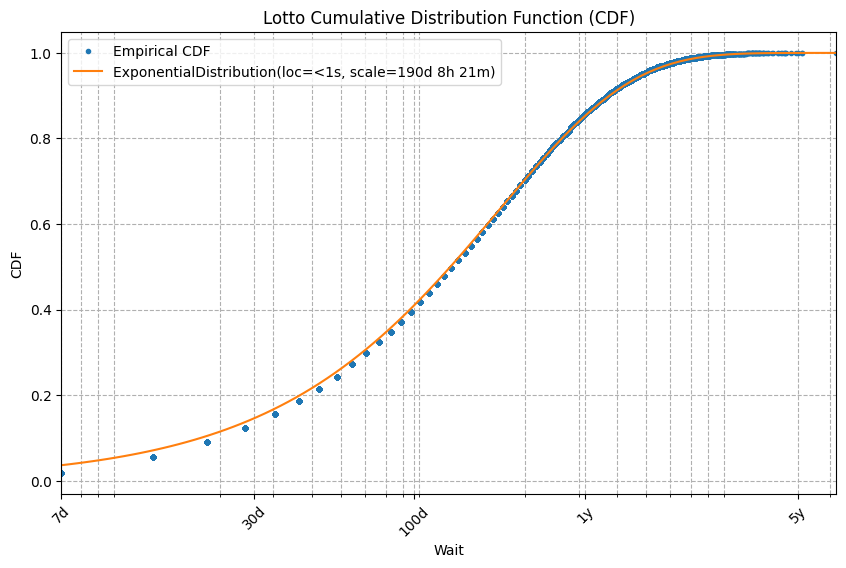

In [58]:
from scipy.stats import expon

lotto_df['CDF'] = lotto_df['Time Delta'].rank(pct=True)

loc, scale = expon.fit(lotto_df['Time Delta'].dt.total_seconds(), floc=0)
lotto_expon_dist = expon(loc=loc, scale=scale)
lotto_expon_label = f'ExponentialDistribution(loc={seconds_to_text(loc)}, scale={seconds_to_text(scale)})'

wait_cdf("Lotto", lotto_df, wiki_wait_ticks, dist=lotto_expon_dist, dist_label=lotto_expon_label, xscale='log')


In [ ]:
# cmk you can generate random waits directly without simulation or simulate followed by resampling
# You can answer questions about very unlikely events without needing to simulate them
# You can described them with just a few numbers.
# If you know the a property of the distribution, you know more about the empirical data (memoryless) - and visa versa

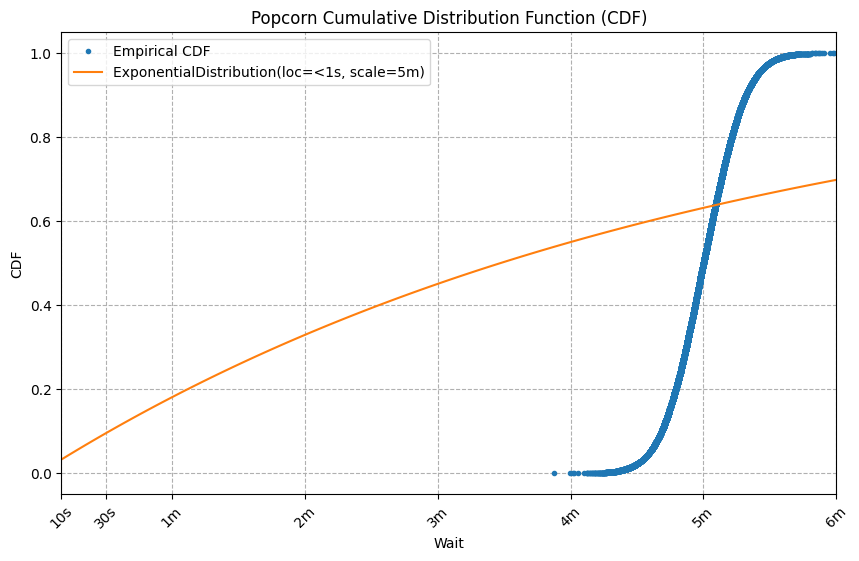

In [57]:
popcorn_df['CDF'] = popcorn_df['Time Delta'].rank(pct=True)

loc, scale = expon.fit(popcorn_df['Time Delta'].dt.total_seconds(), floc=0)
popcorn_expon_dist = expon(loc=loc, scale=scale)
popcorn_df_expon_label = f'ExponentialDistribution(loc={seconds_to_text(loc)}, scale={seconds_to_text(scale)})'

wait_cdf("Popcorn", popcorn_df, popcorn_ticks, dist=popcorn_expon_dist, dist_label=popcorn_df_expon_label, left=10, right=6*60, xscale='linear' )

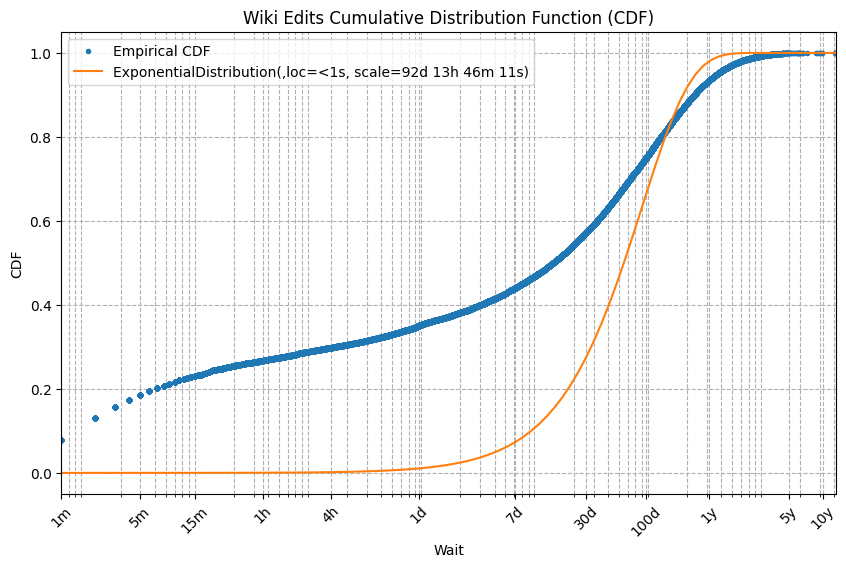

In [69]:
wiki_df['CDF'] = wiki_df['Time Delta'].rank(pct=True)

loc, scale = expon.fit(wiki_df['Time Delta'].dt.total_seconds(), floc=0)
wiki_expon_dist = expon(loc=loc, scale=scale)
wiki_df_expon_label = f'ExponentialDistribution(,loc={seconds_to_text(loc)}, scale={seconds_to_text(scale)})'

wait_cdf("Wiki Edits", wiki_df, wiki_wait_ticks, dist=wiki_expon_dist, dist_label=wiki_df_expon_label, xscale='log', left=60)

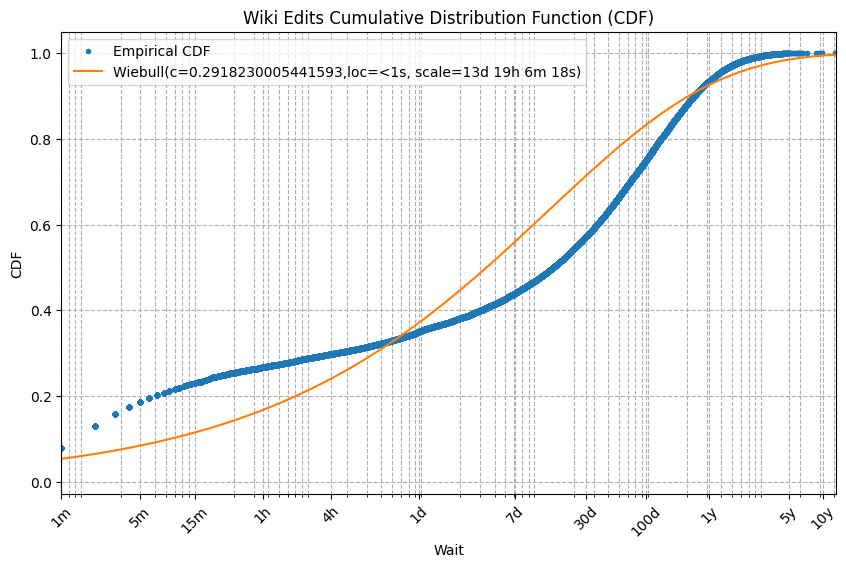

In [55]:
from scipy.stats import weibull_min

wiki_df['CDF'] = wiki_df['Time Delta'].rank(pct=True)

c, loc, scale = weibull_min.fit(wiki_df['Time Delta'].dt.total_seconds(), floc=0)
wiki_weibull_dist = weibull_min(c=c, loc=loc, scale=scale)
wiki_df_weibull_label = f'Wiebull(c={c},loc={seconds_to_text(loc)}, scale={seconds_to_text(scale)})'

wait_cdf("Wiki Edits", wiki_df, wiki_wait_ticks, dist=wiki_weibull_dist, dist_label=wiki_df_weibull_label, xscale='log', left=60)

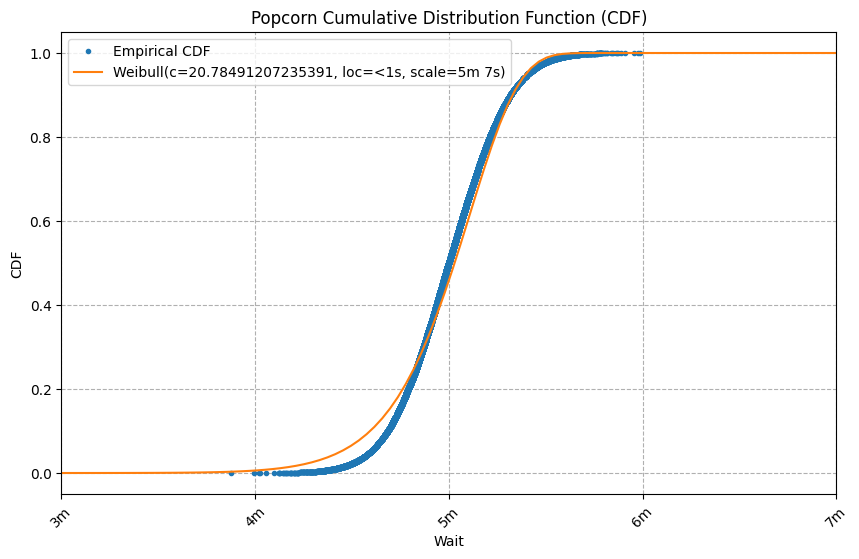

In [67]:
popcorn_df['CDF'] = popcorn_df['Time Delta'].rank(pct=True)

c, loc, scale = weibull_min.fit(popcorn_df['Time Delta'].dt.total_seconds(), floc=0)
popcorn_weibull_dist = weibull_min(c=c, loc=loc, scale=scale)
popcorn_df_weibull_label = f'Weibull(c={c}, loc={seconds_to_text(loc)}, scale={seconds_to_text(scale)})'

wait_cdf("Popcorn", popcorn_df, popcorn_ticks, dist=popcorn_weibull_dist, dist_label=popcorn_df_weibull_label, left=3*60, right=7*60, xscale='linear' )

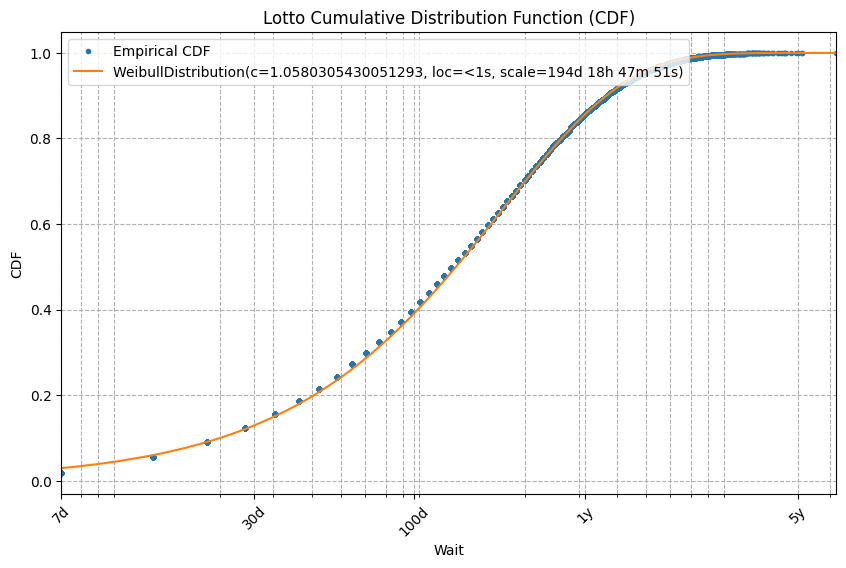

In [73]:
c, loc, scale = weibull_min.fit(lotto_df['Time Delta'].dt.total_seconds(), floc=0)
lotto_weibull_dist = weibull_min(c=c,loc=loc, scale=scale)
lotto_weibull_label = f'WeibullDistribution(c={c}, loc={seconds_to_text(loc)}, scale={seconds_to_text(scale)})'

wait_cdf("Lotto", lotto_df, wiki_wait_ticks, dist=lotto_weibull_dist, dist_label=lotto_weibull_label, xscale='log')